In [1]:
import numpy as np
import matplotlib.pyplot as plt

first, generate a random positive-definite function with a finite integral. I tried to make Claude do this, but it failed, so I've just taken the [Cauchy distribution](https://en.wikipedia.org/wiki/Cauchy_distribution) and multiplied it by a $\sin^2(x)$ term to make it a little funkier. this will be $f(s)$, which is just our target distribution, $p(s)$, up to an unknown scaling factor. (since $f$ is positive-definite with a finite integral, we can multiply it by some positive constant to get a positive-definite function with an integral of 1: in other words, a probability density function. in this case, it's not too bad to calculate the integral, but it's possible in real life we had some wicked function that we could not integrate analytically, in which case rejection sampling is a super nice way of recovering our PDF.)

In [2]:
def weird_f(x):
    return np.sin(x)**2 / (2 * (1 + x**2))

now, to check out work.

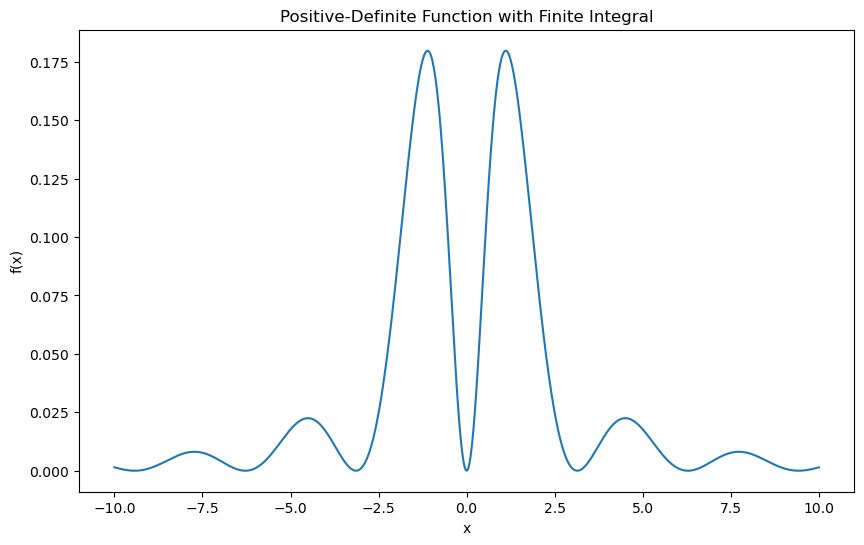

In [3]:
# create function inputs
x = np.linspace(-10, 10, 1000)

# calculate function outputs
y = weird_f(x)

# plot function
plt.figure(figsize=(10, 6))
plt.plot(x, y)
plt.title("Positive-Definite Function with Finite Integral")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.show()


we can check the integral with the trapezoid rule. its value in the limit is not immediately clear.

In [4]:
integral = np.trapz(y, x)
print(f'approximate integral of the function: {integral:.4f}')

approximate integral of the function: 0.6271


now for the magic. we cover our $f(s)$ with some $M * g(s)$. $g(s)$ can be any probability density function, and $M$ must be sufficiently large that $M*g(s) \geq f(s), \forall s \in (-\infty, \infty)$. to make it easy, we'll make $g$ a Gaussian with $\sigma = 4$.

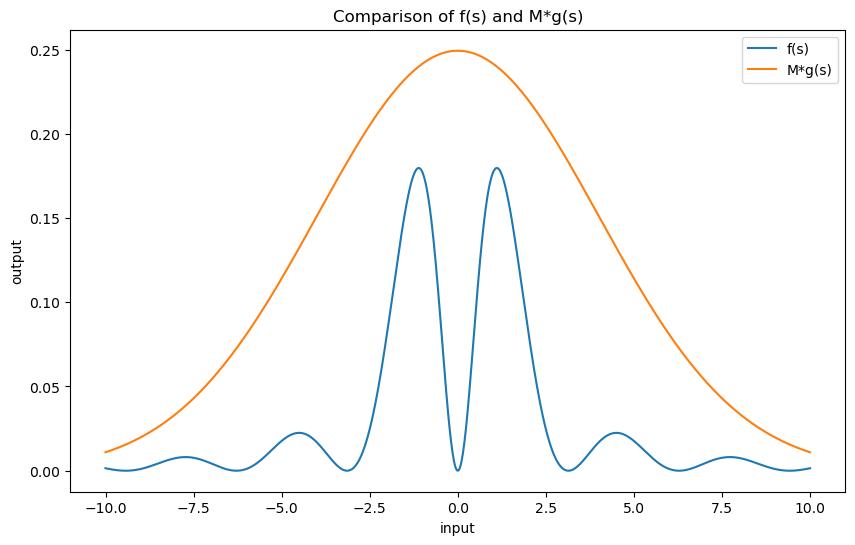

In [5]:
def g(s):
    return (1 / (4**2 * np.sqrt(2 * np.pi))) * np.exp((-1/2) * (s / 4)**2)

def M_g(s):
    return 10 * g(s)

# Plot f(s) and M*g(s) to visually confirm M*g(s) >= f(s)
plt.figure(figsize=(10, 6))
plt.plot(x, y, label='f(s)')
plt.plot(x, M_g(x), label='M*g(s)')
plt.title("Comparison of f(s) and M*g(s)")
plt.xlabel("input")
plt.ylabel("output")
plt.legend()
plt.show()


I haven't checked that $M*g(s) \geq f(s)$ for all $s$, but it is close enough for this demo. this operation works most quickly if $M*g$ only barely covers $f$ (as we will see in a moment), but it will not fail for $M$ being too large.

now, we generate a random value from $g(s)$. (we'll operate in increments of 0.05 to keep everything from vanishing, since I don't actually know how to do stats in Python.)

In [6]:
# generate a random value from PDF g(s)
def generate_from_g():
    value = np.random.normal(0, 4)
    return np.round(value / 0.05) * 0.05

x = generate_from_g()
print(x)

-2.1


the probability that we keep a value—that is, the probability that we take it as part of $p(s)$—is simply $\frac{f(s)}{M*g(s)}$. (derivation, of course, left as an exercise to the reader. it is not too hard to show, and it's what's soooo cool about this technique.)

In [11]:
prob_keep = weird_f(x) / (10 * g(x))
print(f'we take {x} as a part of p(s) if the random number we generate is less than {prob_keep:.3f}.')

we take -2.1 as a part of p(s) if the random number we generate is less than 0.317.


let's do this a bunch and see how close we come to recovering $p(s)$.

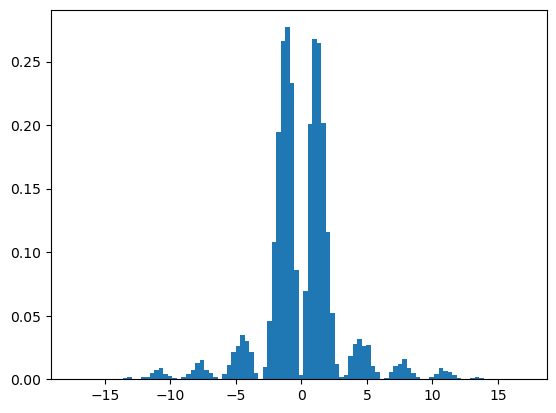

In [12]:
samples = []
for _ in range(50000):
    x = generate_from_g()
    prob_keep = weird_f(x) / (10 * g(x))
    if np.random.random() < prob_keep:
        samples.append(x)

plt.hist(samples, bins=100, density=True)
plt.show()

in other words, we have some wicked function $f(s)$ that's PDF-like, and we want to turn into a PDF, but we don't know how. we choose some $g$ that we can easily sample from, and we scale it up by some $M$ so that it bounds $f$ from above. we sample from $g$, and add our sample reconstructed $p$ with a probability given by the ratio of $f$ to $M*g$ at that value. even with my super hacky Python, we can see fairly clearly that our weird little $p$ is being rebuilt.